In [1]:
import ee
ee.Authenticate()
ee.Initialize()

In [2]:
import os, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
datapath='C:/Djamai_Najib/1_vegetation_parameters/1_scripts/LEAF-Toolbox-master/LEAF-Landsat-Validation-paper/data/S2_SL2PV0/'

## Merge input pkl files

In [5]:
# var ='fAPAR'
# period_max=3000
# ifiles=[ff for ff in os.listdir(datapath) if ff.endswith('0.pkl') and var in ff and int(ff[-8:-4])<=period_max]
# print('Mereging files: %s'%(ifiles))
# for ff in ifiles:
#     with open(os.path.join(datapath,ff), "rb") as fp:   #Pickling
#         feature = pickle.load(fp)
#     if ff==ifiles[0]:
#         sampleDictionary=feature
#         ofn=ff[:-4]
#     else:
#         sampleDictionary[list(sampleDictionary.keys())[0]]=sampleDictionary[list(sampleDictionary.keys())[0]]+feature[list(feature.keys())[0]]
#         ofn=ofn+'_'+ff[-8:-4]
# with open(os.path.join(datapath,ofn+'.pkl'), "wb") as fp:   #Pickling
#         pickle.dump(sampleDictionary, fp)               

## Browse input data

In [6]:
# parameters for validation figures and  statistics 
sampleLAIFileName = os.path.join(datapath,'NEON_2013-22_RMs_updated_parsed_LAI_0_1500.pkl')
samplefCOVERFileName = os.path.join(datapath,'NEON_2013-22_RMs_updated_parsed_fCOVER_0_1500.pkl')
samplefAPARFileName = os.path.join(datapath,'NEON_2013-22_RMs_updated_parsed_fAPAR_0_1500.pkl')

## Classes definition

In [7]:
# renames columns of in-situ validation samples to standard names
def renameColumns(siteDF) :
    if 'GBOV' in os.path.split(os.path.abspath(siteDF.name))[-1]:   
        siteDF['network'] = 'GBOV'
        newNames = {'Site': 'Site', \
                        'FCOVER_down': 'fCOVER_down', \
                        'FCOVER_up': 'fCOVER_up', \
                        'FCOVER_down_err': 'fCOVER_down_err', \
                        'FCOVER_up_err': 'fCOVER_up_err', \
                        'FIPAR_down': 'fAPAR_down', \
                        'FIPAR_up': 'fAPAR_up', \
                        'FIPAR_down_err': 'fAPAR_down_err', \
                        'FIPAR_up_err': 'fAPAR_up_err', \
                        'LAI_Warren_up': 'PAI_up', \
                        'LAI_Warren_down': 'PAI_down', \
                        'LAIe_Warren_up': 'PAIe_up', \
                        'LAIe_Warren_down': 'PAIe_down', \
                        'LAIe_Miller_up': 'PAIe_Miller_up', \
                        'LAIe_Miller_down': 'PAIe_Miller_down', \
                        'LAI_Warren_up_err': 'PAI_up_err', \
                        'LAI_Warren_down_err': 'PAI_down_err', \
                        'LAIe_Warren_up_err': 'PAIe_up_err', \
                        'LAIe_Warren_down_err': 'PAIe_down_err', \
                        'LAIe_Miller_up_err': 'PAIe_Miller_up_err', \
                        'LAIe_Miller_down_err': 'PAIe_Miller_down_err'} 
    elif 'CCRS' in os.path.split(os.path.abspath(siteDF.name))[-1]:
        siteDF['network'] = 'CCRS'
        siteDF['IGBP_class'] = 'Mixed Forest'
        siteDF.loc[siteDF['BF']>0.75,'IGBP_class'] = 'Deciduous Broadleaf'
        siteDF.loc[siteDF['BF']<0.25,'IGBP_class'] = 'Evergreen Needleleaf'
        newNames = {'Location': 'Site', \
                    'BF' : 'fBroadleaf' , \
                    'NF': 'fNeedleafleaf' , \
                    'fcover_Down': 'fCOVER_down', \
                    'fcover_Up': 'fCOVER_up', \
                    'fcoverstd_Down': 'fCOVER_down_err', \
                    'fcoverstd_Up': 'fCOVER_up_err', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sk_yfAPAR_Up': 'fAPAR_up' , \
                    'Daily_Integrated_Black_Sky_fAPAR_Down': 'fAPAR_down', \
                    'Daily_Integrated_Black_Sky_fAPAR_Up': 'fAPAR_up' , \
                    'PAICEV61_Up': 'PAI_up', \
                    'PAICEV61_Down': 'PAI_down', \
                    'PAIeCEV61_Up': 'PAIe_up', \
                    'PAIeCEV61_Down':'PAIe_down', \
                    'PAIEMiller_Up': 'PAIe_Miller_up', \
                    'PAIEMiller_Down':'PAIe_Miller_down', \
                    'Woody_Fraction_average':'WAItoPAIratio', \
                    'Woody_Fraction_std': 'WAItoPAIratio_std' }  

    elif 'NEON' in os.path.split(os.path.abspath(siteDF.name))[-1]:
        siteDF['network'] = 'NEON'
        newNames = {'SITE': 'Site', \
                    'PLOT_ID':'PlotID',\
                    'nlcd':'NLCD_class',\
                    'clumping_index_Miller_understoryest' : 'clumping_Miller_down' , \
                    'clumping_index_Miller_understoryerror': 'clumping_Miller_down_err' , \
                    'clumping_index_Miller_overstoryest': 'clumping_Miller_up', \
                    'clumping_index_Miller_overstoryerror': 'clumping_Miller_up_err', \
                    'clumping_index_Warren_understoryest': 'clumping_Warren_down', \
                    'clumping_index_Warren_understoryerror': 'clumping_Warren_down_err', \
                    'clumping_index_Warren_overstoryest': 'clumping_Warren_up', \
                    'clumping_index_Warren_overstoryerror': 'clumping_Warren_up_err' , \
                    'datetime': 'Date', \
                    'understory_flag': 'down_flag' , \
                    'FIPAR_understoryest': 'fAPAR_down', \
                    'FIPAR_understoryerror': 'fAPAR_down_err', \
                    'FIPAR_overstoryest': 'fAPAR_up', \
                    'FIPAR_overstoryerror':'fAPAR_up_err', \
                    'FCOVER_understoryest': 'fCOVER_down', \
                    'FCOVER_understoryerror':'fCOVER_down_err', \
                    'FCOVER_overstoryest':'fCOVER_up', \
                    'FCOVER_overstoryerror': 'fCOVER_up_err', \
                    
                    'true_LAI_Miller_understoryest':'PAI_Miller_down', \
                    'true_LAI_Miller_understoryerror':'PAI_Miller_down_err', \
                    'true_LAI_Miller_overstoryest':'PAI_Miller_up', \
                    'true_LAI_Miller_overstoryerror':'PAI_Miller_up_err', \
                    'true_LAI_Warren_understoryest':'PAI_Warren_down', \
                    'true_LAI_Warren_understoryerror':'PAI_Warren_down_err', \
                    'true_LAI_Warren_overstoryest':'PAI_Warren_up', \
                    'true_LAI_Warren_overstoryerror':'PAI_Warren_up_err', \
                    
                    'effective_LAI_Miller_understoryest':'PAIe_down', \
                    'effective_LAI_Miller_understoryerror':'PAIe_down_err', \
                    'effective_LAI_Miller_overstoryest':'PAIe_up', \
                    'effective_LAI_Miller_overstoryerror':'PAIe_up_err', \
                    'effective_LAI_Warren_understoryest':'PAIe_Warren_down', \
                    'effective_LAI_Warren_understoryerror':'PAIe_Warren_down_err', \
                    'effective_LAI_Warren_overstoryest':'PAIe_Warren_up', \
                    'effective_LAI_Warren_overstoryerror':'PAIe_Warren_up_err', \
                    'PLOT_ID':'PLOT_ID', \
                    'timeStart':'timeStart', \
                    'overstory_flag':'up_flag', \
                    'combined_flag':'combined_flag'}
                    
    return  siteDF.rename(columns = newNames)

In [8]:
def rename_nlcd_class (samplesDF) :
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'evergreenForest')           ,'NLCD_class'] = 'Evergreen Forest'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'deciduousForest')           ,'NLCD_class'] = 'Deciduou sForest' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'mixedForest')               ,'NLCD_class'] = 'Mixed Forest'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'cultivatedCrops')           ,'NLCD_class'] = 'Cultivated Crops'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'pastureHay')                ,'NLCD_class'] = 'Pasture Hay' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'dwarfScrub')                ,'NLCD_class'] = 'Dwarf Scrub'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'shrubScrub')                ,'NLCD_class'] = 'Shrub Scrub' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'woodyWetlands')             ,'NLCD_class'] = 'Woody Wetlands' 
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'emergentHerbaceousWetlands'),'NLCD_class'] = 'Emergent Herbaceous Wetlands'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'sedgeHerbaceous')           ,'NLCD_class'] = 'Sedge Herbaceous'
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'grasslandHerbaceous')       ,'NLCD_class'] = 'Grassland Herbaceous'
    return (samplesDF)

In [9]:
def format_feature0(feat,variablename):
    D=dict()
    for key in feat.keys():
        cols=list(feat[key][0].keys())
        A=[feat[key][ii][cols[0]] for ii in range(len(feat[key]))]
        B=[feat[key][ii][cols[1]] for ii in range(len(feat[key]))]
        for ii in range(len(feat[key])):
            A[ii]['sample%s'%(variablename)]=B[ii]
        D.update({key:A}) 
    return D

In [10]:
def estimateWAItoPAIratio(samplesDF) :
    #estimate overstory woody to total area ratio for NEON sites
    # use initial fixed ratio for all sites based on shrubs 
    samplesDF.loc[(samplesDF['network'] == 'NEON') ,'WAItoPAIratio'] = 0.10
    samplesDF.loc[(samplesDF['network'] == 'NEON') ,'WAItoPAIratio_std'] = 0.11

    # use fixed ratio for needeleaf sites
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Needleleaf'),'WAItoPAIratio_std'] = 0.10   
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio'] = 0.16
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Needleleaf'),'WAItoPAIratio_std'] = 0.10  

    # use fixed ratio for  broadleaf sites
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Evergreen Broadleaf'),'WAItoPAIratio_std'] = 0.11
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio'] = 0.24
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Deciduous Broadleaf'),'WAItoPAIratio_std'] = 0.11


    # use fixed ratio for mixed forest
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Mixed Forest'),'WAItoPAIratio'] = 0.18
    samplesDF.loc[(samplesDF['network'] == 'NEON') & (samplesDF['NLCD_class'] == 'Mixed Forest'),'WAItoPAIratio_std'] = 0.11
    return (samplesDF)

In [11]:
# parses a file of matchups to create dataframe woth required entries for validation statistics and figures
def parseSampleFile(sampleFileName,variableName):

# clumping uncertainty
    clumping_err = 0.025
    WAItoPAIdown= 0.1
    
    with open(sampleFileName, "rb") as fp:   #Pickling
        sampleDictionary = pickle.load(fp)
    sitesList = sampleDictionary.keys()
    samplesDF = pd.DataFrame();
    
    for key in sitesList:
        #convert list to pandas data frame, rename columns, filter for North America
        siteDF = pd.concat([pd.DataFrame(sampleDictionary[key]),pd.DataFrame([key] * len(sampleDictionary[key]),columns=['geeFeatureCollection'])],axis=1)
        siteDF.name = key
        siteDF = renameColumns(siteDF)

        #number of samples and number valid samples
        numValid = []
        numSamples = []
        list(siteDF)

        for index,site in siteDF.iterrows():
            siteQC = site['sample'+variableName][1]['data']
            numSamples.append(len(siteQC))
            numValid.append(len(siteQC) - np.count_nonzero(siteQC))
        numSamplesDF= pd.DataFrame(numSamples,columns=['numSamples'])
        numValidDF = pd.DataFrame(numValid,columns=['numValid'])
        siteDF = pd.concat([siteDF,numSamplesDF, numValidDF],axis=1)
        samplesDF = pd.concat([samplesDF,siteDF],axis=0,ignore_index=True)
    
    samplesDF = samplesDF.reset_index(drop=True)
    if variableName == 'LAI' :
        lai_algo='Miller'
        samplesDF['PAI_up']      =samplesDF['PAI_'+lai_algo+'_up']
        samplesDF['PAI_down']    =samplesDF['PAI_'+lai_algo+'_down']
        samplesDF['PAI_up_err']  =samplesDF['PAI_'+lai_algo+'_up_err']
        samplesDF['PAI_down_err']=samplesDF['PAI_'+lai_algo+'_down_err']
        
        samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']] = samplesDF[['PAI_up','PAI_down','PAIe_up','PAIe_down','PAI_up_err','PAI_down_err','PAIe_up_err','PAIe_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)

        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_up'].mul(0.04830027).add(0.002163865830433743)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAIe_down'].mul(0.04830027).add(0.002163865830433743)        
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_up'].mul(0.04480655).add(0.010224858872736227)
        samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','PAI_down'].mul(0.04480655).add(0.010224858872736227)

        samplesDF['percentValid'] = samplesDF['numValid'].div(samplesDF['numSamples'])
        
        # add error due to uncertainty in clumping
        samplesDF['PAI_up_err_clumping'] = samplesDF['PAI_up'].mul(samplesDF['PAI_up'].div((samplesDF['PAIe_up']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_up_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_up_err_clumping'].pow(2)).pow(0.5)
        samplesDF['PAI_down_err_clumping'] = samplesDF['PAI_down'].mul(samplesDF['PAI_down'].div((samplesDF['PAIe_down']).add(0.0001)).mul(clumping_err))
        samplesDF['PAI_down_err'] = samplesDF['PAI_down_err'].pow(2).add(samplesDF['PAI_down_err_clumping'].pow(2)).pow(0.5)

        #compute total canopy values including woody area
        samplesDF['PAI_total'] = samplesDF['PAI_up'].add(samplesDF['PAI_down']) 
        samplesDF['PAI_total_err'] = samplesDF['PAI_up_err'].pow(2).add(samplesDF['PAI_down_err'].pow(2)).pow(0.5)
        samplesDF['PAIe_total'] = samplesDF['PAIe_up'].add(samplesDF['PAIe_down']) 
        samplesDF['PAIe_total_err'] = samplesDF['PAIe_up_err'].pow(2).add(samplesDF['PAIe_down_err'].pow(2)).pow(0.5)
        samplesDF['clumping_total'] = samplesDF['PAIe_total'].div(samplesDF['PAI_total'] ) 
        samplesDF['clumping_total_err']  = (2 * clumping_err  * clumping_err) ** (0.5)          
         #compute total canopy values depending to removing woddy area
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF['LAI_up'] = samplesDF['PAI_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_up_err'] = samplesDF['PAI_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAI_down'] = samplesDF['PAI_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_down_err'] = samplesDF['PAI_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAI_total'] = samplesDF['LAI_up'] + samplesDF['LAI_down']
        samplesDF['LAI_total_err'] = samplesDF['LAI_down_err'].pow(2).add(samplesDF['LAI_up_err'].pow(2)).pow(0.5)                                                                           
        samplesDF['LAIe_up'] = samplesDF['PAIe_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_up_err'] = samplesDF['PAIe_up_err'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['LAIe_down'] = samplesDF['PAIe_down'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_down_err'] = samplesDF['PAIe_down_err'] * ( 1 - WAItoPAIdown)
        samplesDF['LAIe_total'] = samplesDF['LAIe_up'] + samplesDF['LAIe_down']
        samplesDF['LAIe_total_err'] = samplesDF['LAIe_down_err'].pow(2).add(samplesDF['LAIe_up_err'].pow(2)).add(samplesDF['LAI_up'].mul(samplesDF['LAI_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)                                                             
    elif variableName == 'fCOVER' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']] = samplesDF[['fCOVER_up','fCOVER_down','fCOVER_up_err','fCOVER_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fCOVER_up'] = samplesDF['fCOVER_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fCOVER_down'] = samplesDF['fCOVER_down'] * ( 1 - WAItoPAIdown)
        samplesDF['fCOVER_total'] = samplesDF['fCOVER_up'].add((samplesDF['fCOVER_up'].mul(-1).add(1)).mul(samplesDF['fCOVER_down'] ))
        samplesDF['fCOVER_total_err'] = samplesDF['fCOVER_down_err'].pow(2).add(samplesDF['fCOVER_up_err'].pow(2)).add(samplesDF['fCOVER_up'].mul(samplesDF['fCOVER_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    elif  variableName == 'fAPAR' :
        samplesDF = estimateWAItoPAIratio(samplesDF)
        samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']] = samplesDF[['fAPAR_up','fAPAR_down','fAPAR_up_err','fAPAR_down_err']].apply(pd.to_numeric)
        samplesDF = samplesDF.replace(-999, 0)
        samplesDF['fAPAR_up'] = samplesDF['fAPAR_up'] * (1-samplesDF['WAItoPAIratio'])
        samplesDF['fAPAR_down'] = samplesDF['fAPAR_down'] * ( 1 - WAItoPAIdown)
        samplesDF['percentValid'] = samplesDF['numValid'] / samplesDF['numSamples']
        samplesDF['fAPAR_total'] = samplesDF['fAPAR_up'].add((samplesDF['fAPAR_up'].mul(-1).add(1)).mul(samplesDF['fAPAR_down'] ))
        # gap fill estimates of insitu error for CCRS
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_up']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down_err'] = samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down'].add(-0.5).abs().mul(-0.08437372).add(0.04791396358018562).mul(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_down']).div(samplesDF.loc[samplesDF['network'] == 'CCRS','fAPAR_total'])
        samplesDF['fAPAR_total_err'] = samplesDF['fAPAR_down_err'].pow(2).add(samplesDF['fAPAR_up_err'].pow(2)).add(samplesDF['fAPAR_up'].mul(samplesDF['fAPAR_up'].mul(samplesDF['WAItoPAIratio_std'])).pow(2)).pow(0.5)  
    else :
        print('variable not found')
              
    return(samplesDF)
                           

In [12]:
# compute residuals
def summaryStats(samplesDF,samplesLAIDF,xvariable,yvariable,trimquantile,minPAI):
    estimateMedian = [] 
    estimateSTD = [] 
    medianError = [] 
    estimateCount = [] 
    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    
    for index, sample in samplesDF.iterrows():
        reference = sample[yvariable]
        qc = sample['sample'+xvariable][1]['data']
        estimate = sample['sample'+xvariable][2]['data']
        error = sample['sample'+xvariable][5]['data']
        productDF = pd.DataFrame(list(zip(qc,estimate,error)),columns=['qc','estimate','error'])
        #productDF = productDF.loc[productDF['qc']==0]
        if productDF.shape[0]>0 :
            productDF['absresidual'] = (productDF['estimate'] - reference).abs()
            quantileResidual = productDF['absresidual'].quantile(trimquantile/100,interpolation='nearest')
            estimateMedian.append(productDF.loc[productDF['absresidual']==quantileResidual]['estimate'].mean())
            estimateSTD.append(productDF.loc[productDF['absresidual']<=quantileResidual,['estimate']].std().divide((productDF.loc[productDF['absresidual']<=quantileResidual].shape[0]) ** (0.5)))
            medianError.append(productDF.loc[productDF['absresidual']==quantileResidual]['error'].median())
            estimateCount.append(productDF.loc[productDF['absresidual']<=quantileResidual].shape[0])
        else:
            estimateMedian.append(np.nan)
            estimateSTD.append(np.nan)
            medianError.append(np.nan)
            estimateCount.append(0)
    samplesDF[xvariable+'_'+yvariable+'_estimate'] = estimateMedian
    samplesDF[xvariable+'_'+yvariable+'_estimate_std'] = estimateSTD 
    samplesDF[xvariable+'_'+yvariable+'_err_estimate_mean'] = medianError
    samplesDF[xvariable+'_'+yvariable+'_estimate_count'] = estimateCount
    return(samplesDF)

In [13]:
# plots accuracy precision and uncertainty curves based on residuals by fitting a polynomial of specified degree
def plotSummaryStats(x,y,err,axis,degree):
    from sklearn.preprocessing import PolynomialFeatures
    poly = PolynomialFeatures(degree = degree)
    xp = poly.fit_transform(x.reshape(-1,1))
    accSummary = sm.WLS(y, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    pre = abs(y-np.array(accSummary['mean']))
    preSummary = sm.WLS(pre, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    unc = abs(y)
    # print(sm.WLS(y, xp, err ** (-2)).fit().summary())
    # print(sm.WLS(pre, xp, err ** (-2)).fit().summary())

    uncSummary = sm.WLS(unc, xp, err ** (-2)).fit().get_prediction(xp) .summary_frame(alpha=0.05)
    axis.plot(x, accSummary['mean'], color='darkgreen', label='Accuracy')
    axis.plot(x, accSummary['mean_ci_upper'], color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, accSummary['mean_ci_lower'],color='darkgreen',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean'], color='darkorange', label='Precision')
    axis.plot(x, preSummary['mean_ci_upper'], color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, preSummary['mean_ci_lower'],color='darkorange',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean'], color='royalblue', label='Uncertainty')
    axis.plot(x, uncSummary['mean_ci_upper'], color='royalblue',linewidth=0.5,linestyle='--')
    axis.plot(x, uncSummary['mean_ci_lower'],color='royalblue',linewidth=0.5,linestyle='--')
    
    return

In [14]:
# get summary stats after trimming quantiles of residuals to remove outliers due to poor matching
# we get stats for each quantile from 10 to 100%
samplesList = []

for p in range(10,110,10):
    print(p)
    samplesLAIDF = summaryStats(parseSampleFile(sampleLAIFileName,'LAI'),parseSampleFile(sampleLAIFileName,'LAI'),'LAI','PAIe_total',p,0.01).reset_index(drop=True) #.drop(['fCOVER_up','fCOVER_down','fAPAR_up','fAPAR_down','fCOVER_up_std','fCOVER_down_std','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfAPARDF = summaryStats(parseSampleFile(samplefAPARFileName,'fAPAR'),parseSampleFile(sampleLAIFileName,'LAI'),'fAPAR','fAPAR_total',p,0.01).reset_index(drop=True) #.drop(['fAPAR_up','fAPAR_down','fAPAR_up_std','fAPAR_down_std'],axis=1)
    samplesfCOVERDF = summaryStats(parseSampleFile(samplefCOVERFileName,'fCOVER'),parseSampleFile(sampleLAIFileName,'LAI'),'fCOVER','fCOVER_total',p,0.01).reset_index(drop=True)

    samplesDF = samplesfAPARDF[['fAPAR_up','fAPAR_down','fAPAR_total','fAPAR_up_err','fAPAR_down_err','fAPAR_total_err','samplefAPAR','fAPAR_fAPAR_total_estimate','fAPAR_fAPAR_total_estimate_std','fAPAR_fAPAR_total_err_estimate_mean','fAPAR_fAPAR_total_estimate_count']] \
                .join(samplesfCOVERDF[['fCOVER_up','fCOVER_down','fCOVER_total','fCOVER_up_err','fCOVER_down_err','fCOVER_total_err','samplefCOVER','fCOVER_fCOVER_total_estimate','fCOVER_fCOVER_total_estimate_std','fCOVER_fCOVER_total_err_estimate_mean','fCOVER_fCOVER_total_estimate_count']])
    
    samplesDF = samplesDF.join(samplesLAIDF[samplesLAIDF.columns.difference(samplesDF.columns)])
    
    #samplesDF = samplesDF[samplesDF['LAI_PAIe_total_estimate_count']>0]
    samplesDF = samplesDF.dropna(subset='fAPAR_fAPAR_total_estimate')
 
    samplesList.append(samplesDF)

10
20
30
40
50
60
70
80
90
100


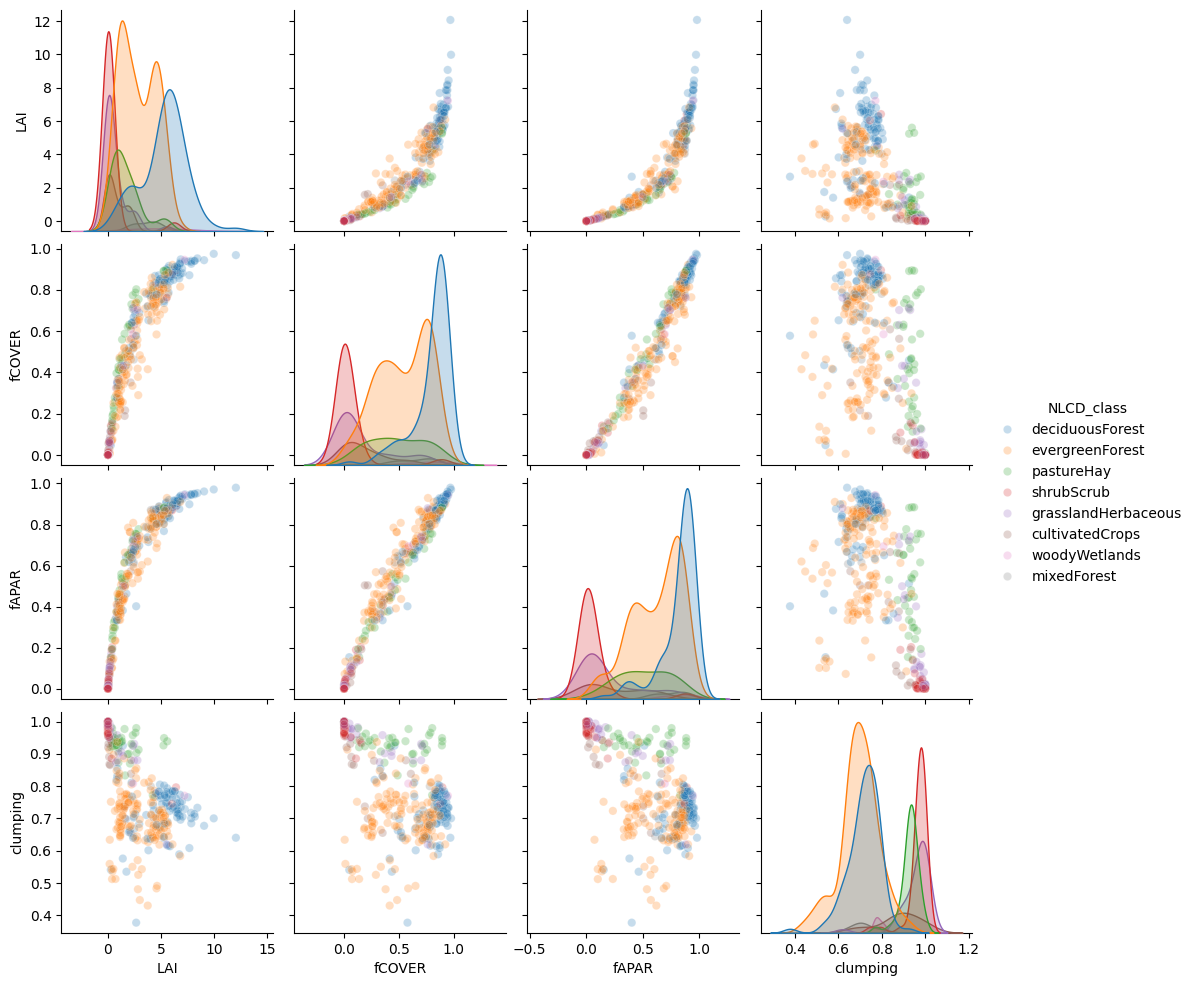

In [15]:
# figure 5a  reference variables by NLCD class
samplesDF = samplesList[0].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','NLCD_class']]
g = sns.pairplot(samplesDFfig1, hue='NLCD_class', markers= 'o',plot_kws={'alpha': 0.25})
plt.savefig('figure5a.png') 

In [16]:
# # figure 5b  reference variables by network
# samplesDF = samplesList[0].rename(columns={'LAI_total':'LAI','fCOVER_total':'fCOVER','fAPAR_total':'fAPAR','clumping_total':'clumping',})
# samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','clumping','network']]
# g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')
# plt.savefig('Figure5b.png')

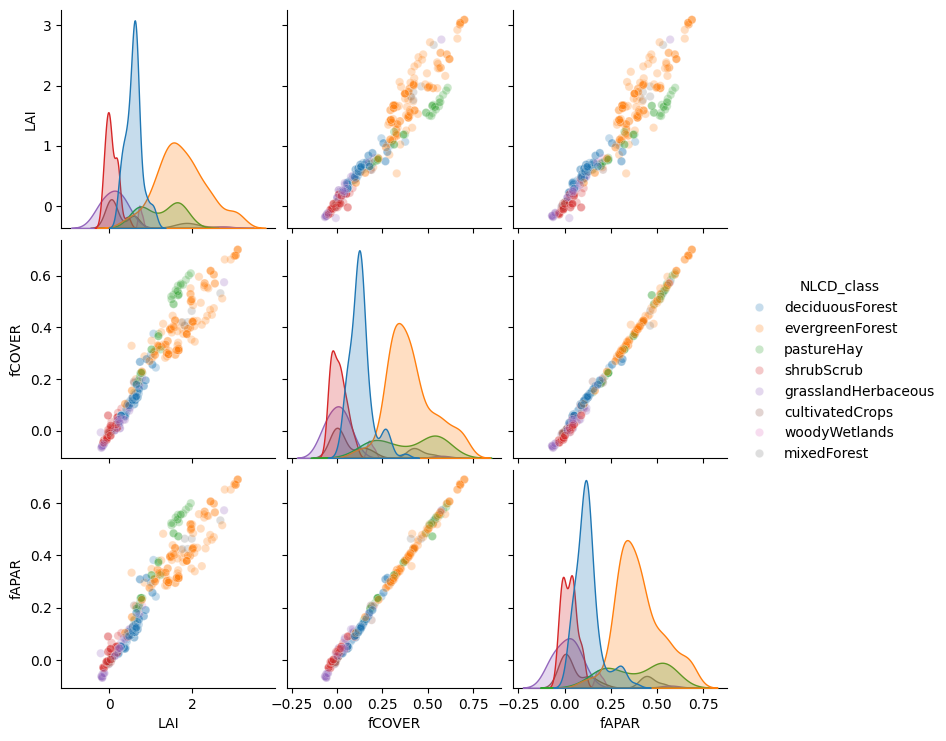

In [17]:
# figure 6a sl2p variables by class
samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR'})
samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','NLCD_class']]
g = sns.pairplot(samplesDFfig1, hue='NLCD_class', markers= 'o',plot_kws={'alpha': 0.25})
plt.savefig('Figure6a.png')

In [18]:
# # figure 6b sl2p variables by network
# samplesDF = samplesList[4].rename(columns={'LAI_PAIe_total_estimate':'LAI','fCOVER_fCOVER_total_estimate':'fCOVER','fAPAR_fAPAR_total_estimate':'fAPAR',})
# samplesDFfig1 = samplesDF[['LAI','fCOVER','fAPAR','network']]
# g = sns.pairplot(samplesDFfig1, hue='network', markers= '+',plot_kws={'alpha': 0.75},palette='muted')
# plt.savefig('Figure6b.png')

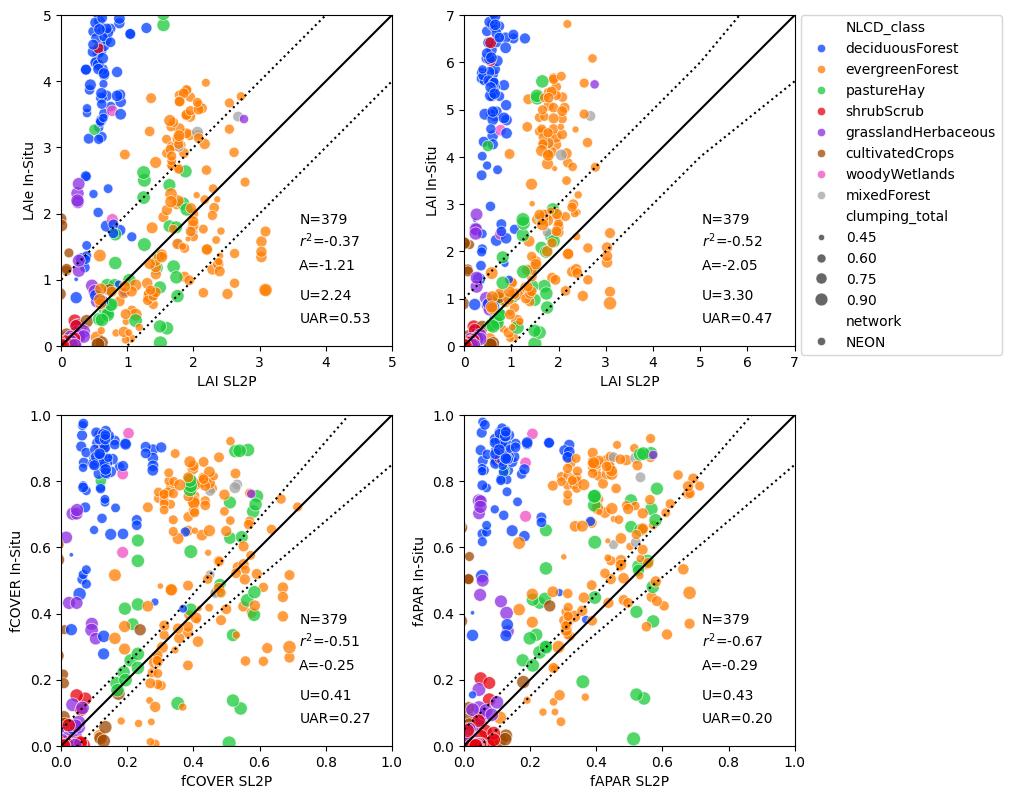

In [19]:
# figure 7

fig, ax = plt.subplots(2,2,constrained_layout = True)
fig.set_size_inches(10 ,8)
data = samplesList[0]

y = data['PAIe_total']
yerror = data['LAIe_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAIe_total', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=0.75,palette="bright", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.maximum(np.linspace(0,6,100)*0.20,1),color='black',linestyle='dotted')
ax[0,0].plot(np.linspace(0,6,100),np.linspace(0,6,100)+np.minimum(-np.linspace(0,6,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,0].plot([0,6],[0,6],color='black')
ax[0,0].set(adjustable='box',aspect='equal')
ax[0,0].set_ylabel('LAIe In-Situ')
ax[0,0].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(1,0.2*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[0,0].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[0,0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[0,0].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[0,0].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[0,0].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['PAI_total']
yerror = data['LAI_total_err']
x = data['LAI_PAIe_total_estimate']
xerror = data['LAI_PAIe_total_err_estimate_mean'].astype('float')
# ax[0,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='LAI_PAIe_total_estimate', y='LAI_total', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[0,1])
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.maximum(np.linspace(0,7,100)*0.20,1),color='black',linestyle='dotted')
ax[0,1].plot(np.linspace(0,7,100),np.linspace(0,7,100)+np.minimum(-np.linspace(0,7,100)*0.20,-1),color='black',linestyle='dotted')
ax[0,1].plot([0,7],[0,7],color='black')
ax[0,1].set(adjustable='box',aspect='equal')
ax[0,1].set_ylabel('LAI In-Situ')
ax[0,1].set_xlabel('LAI SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(1,0.2*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[0,1].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[0,1].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[0,1].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[0,1].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[0,1].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['fCOVER_total']
yerror = data['fCOVER_total_err']
x = data['fCOVER_fCOVER_total_estimate']
xerror = data['fCOVER_fCOVER_total_err_estimate_mean'].astype('float')
# ax[1,0].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.scatterplot(data=data, x='fCOVER_fCOVER_total_estimate', y='fCOVER_total', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,0].plot([0,1],[0,1],color='black')
ax[1,0].set(adjustable='box',aspect='equal')
ax[1,0].set_ylabel('fCOVER In-Situ')
ax[1,0].set_xlabel('fCOVER SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(0.05,0.10*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[1,0].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[1,0].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[1,0].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[1,0].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[1,0].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

y = data['fAPAR_total']
yerror = data['fAPAR_total_err']
x = data['fAPAR_fAPAR_total_estimate']
xerror = data['fAPAR_fAPAR_total_err_estimate_mean'].astype('float')
# ax[1,1].errorbar(x, y,yerr=yerror,xerr=xerror,ls='none', fmt = 'or', ms=0, ecolor='grey',alpha=0.15)
sns.scatterplot(data=data, x='fAPAR_fAPAR_total_estimate', y='fAPAR_total', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(10, 100), alpha=.75, palette="bright", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.maximum(np.linspace(0,1,100)*0.15,0.05),color='black',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.linspace(0,1,100)+np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='black',linestyle='dotted')
ax[1,1].plot([0,1],[0,1],color='black')
ax[1,1].set(adjustable='box',aspect='equal')
ax[1,1].set_ylabel('fAPAR In-Situ')
ax[1,1].set_xlabel('fAPAR SL2P')
n = len(x)
res = np.array(x.sub(y))
unc= np.mean(res ** 2) ** (0.5)
acc = np.mean(res)
uar = np.mean(np.abs(res)<np.maximum(0.05,0.10*x))
r2 = 1 - unc ** 2 / np.var(np.array(y))
ax[1,1].annotate(f'N={n}', xy=(0.72, 0.37), xycoords='axes fraction')
ax[1,1].annotate(f'$r^2$={r2:.2f}', xy=(0.72, 0.30), xycoords='axes fraction')
ax[1,1].annotate(f'A={acc:.2f}', xy=(0.72, 0.23), xycoords='axes fraction')
ax[1,1].annotate(f'U={unc:.2f}', xy=(0.72, 0.14), xycoords='axes fraction')
ax[1,1].annotate(f'UAR={uar:.2f}', xy=(0.72, 0.07), xycoords='axes fraction')

ax[0,0].set_xlim([0,5])
ax[0,1].set_xlim([0,7])
ax[1,0].set_xlim([0,1])
ax[1,1].set_xlim([0,1])
ax[0,0].set_ylim([0,5])
ax[0,1].set_ylim([0,7])
ax[1,0].set_ylim([0,1])
ax[1,1].set_ylim([0,1])
plt.savefig('Figure7Brown.png',bbox_inches='tight')
plt.show()


Series([], Name: WAItoPAIratio_std, dtype: float64)


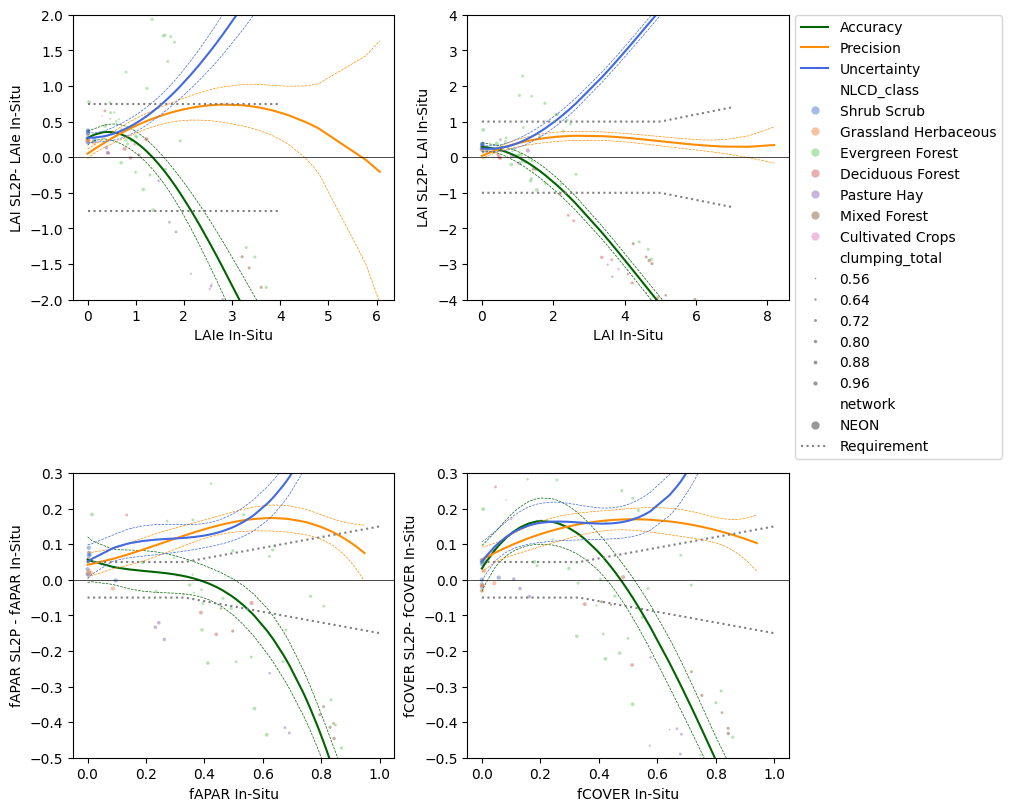

In [24]:
# figure 8


fig, ax = plt.subplots(2, 2,constrained_layout = True)
fig.set_size_inches(10, 8)

percentileToPlot = 4

#LAIe
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAIe_total'] = data['LAIe_total'].add(randomDF['randomCol'])
data = data.sort_values('LAIe_total')
data['LAIe_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAIe_total']))
y = np.array(data['LAIe_residual'])
x = np.array(data['LAIe_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAIe_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,0],3)
sns.scatterplot(data=data, x='LAIe_total', y='LAIe_residual', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,0],legend=False)
ax[0,0].plot(np.linspace(0,4,100),np.maximum(np.linspace(0,4,100)*0.2*0.75,1*0.75),color='grey',linestyle='dotted')
ax[0,0].plot(np.linspace(0,4,100),np.minimum(-np.linspace(0,4,100)*0.2*0.75,-1*0.75),color='grey',linestyle='dotted')
ax[0,0].axhline(y=0,color='black',linewidth=0.5)
ax[0,0].set_ylim([-2,2])
ax[0,0].set_ylabel('LAI SL2P- LAIe In-Situ')
ax[0,0].set_xlabel('LAIe In-Situ')
uarLAIemid = np.sum(np.abs(y)<np.maximum(x*0.15,.5))/y.size

#LAI
data = samplesList[percentileToPlot]
data = data[~data['LAI_PAIe_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['LAI_total'] = data['LAI_total'].add(randomDF['randomCol'])
data = data.sort_values('LAI_total')
data['LAI_residual'] = data['LAI_PAIe_total_estimate'].sub((data['LAI_total']))
y = np.array(data['LAI_residual'])
x = np.array(data['LAI_total'])
err =np.array(((data['LAI_PAIe_total_err_estimate_mean']).pow(2).add((data['LAI_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[0,1],3)
sns.scatterplot(data=data, x='LAI_total', y='LAI_residual', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[0,1],legend=True)
ax[0,1].plot(np.linspace(0,7,100),np.maximum(np.linspace(0,7,100)*0.2,1),color='grey',linestyle='dotted',label='Requirement')
ax[0,1].plot(np.linspace(0,7,100),np.minimum(-np.linspace(0,7,100)*0.2,-1),color='grey',linestyle='dotted')
ax[0,1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
ax[0,1].axhline(y=0,color='black',linewidth=0.5)
ax[0,1].set_ylim([-4,4])
ax[0,1].set_ylabel('LAI SL2P- LAI In-Situ')
ax[0,1].set_xlabel('LAI In-Situ')
uarLAImid = np.sum(np.abs(y)<np.maximum(x*0.15,.5))/y.size

#fAPAR
data = samplesList[percentileToPlot]
data = data[~data['fAPAR_fAPAR_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fAPAR_total'] = data['fAPAR_total'].add(randomDF['randomCol'])


data['fAPAR_residual'] = data['fAPAR_fAPAR_total_estimate'].sub((data['fAPAR_total']))
data = data.sort_values(['fAPAR_total'])

y = np.array(data['fAPAR_residual'])
x = np.array(data['fAPAR_total'])
err =np.array(((data['fAPAR_fAPAR_total_err_estimate_mean']).pow(2).add((data['fAPAR_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
print(data[data['fAPAR_total_err'].isnull()]['WAItoPAIratio_std'])
plotSummaryStats(x,y,err,ax[1,0],3)
sns.scatterplot(data=data, x='fAPAR_total', y='fAPAR_residual', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,0],legend=False)
ax[1,0].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,0].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,0].axhline(y=0,color='black',linewidth=0.5)
ax[1,0].set_ylim([-0.5,0.3])
ax[1,0].set_ylabel('fAPAR SL2P - fAPAR In-Situ')
ax[1,0].set_xlabel('fAPAR In-Situ')
uarfAPARmid = np.sum(np.abs(y)<np.maximum(x*0.10,0.05))/y.size

#fCOVER
data = samplesList[percentileToPlot]
data = data[~data['fCOVER_fCOVER_total_estimate'].isnull()].reset_index()
randomDF = pd.DataFrame(np.random.rand(data.shape[0],1) * 0.0001,columns=['randomCol']).reset_index()
data['fCOVER_total'] = data['fCOVER_total'].add(randomDF['randomCol'])
data['fCOVER_residual'] = data['fCOVER_fCOVER_total_estimate'].sub((data['fCOVER_total']))
data = data.sort_values(['fCOVER_total'])

y = np.array(data['fCOVER_residual'])
x = np.array(data['fCOVER_total'])
err =np.array(((data['fCOVER_fCOVER_total_err_estimate_mean']).pow(2).add((data['fCOVER_total_err']).pow(2))).pow(0.5))
z = np.array(data['PAIe_total'].divide(data['PAI_total']))
plotSummaryStats(x,y,err,ax[1,1],3)

sns.scatterplot(data=data, x='fCOVER_total', y='fCOVER_residual', hue='NLCD_class', style='network', size = 'clumping_total',  sizes=(1, 10), alpha=.5, palette="muted", ax=ax[1,1],legend=False)
ax[1,1].plot(np.linspace(0,1,100),np.maximum(np.linspace(0,1,100)*0.15,0.05),color='grey',linestyle='dotted')
ax[1,1].plot(np.linspace(0,1,100),np.minimum(-np.linspace(0,1,100)*0.15,-0.05),color='grey',linestyle='dotted')
ax[1,1].axhline(y=0,color='black',linewidth=0.5)
ax[1,1].set_ylim([-0.5,0.3])
ax[1,1].set_ylabel('fCOVER SL2P- fCOVER In-Situ')
ax[1,1].set_xlabel('fCOVER In-Situ')
uarfCOVERmid = np.sum(np.abs(y)<np.maximum(x*0.10,0.05))/y.size
plt.savefig('Figure8.png',bbox_inches='tight')

In [13]:
%history

import ee
ee.Authenticate()
ee.Initialize()
import os, pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
datapath='C:/Djamai_Najib/1_vegetation_parameters/1_scripts/LEAF-Toolbox-master/LEAF-Landsat-Validation-paper/data/'
uncomment_if_needed='''
var ='fAPAR'
period_max=3000
ifiles=[ff for ff in os.listdir(datapath) if ff.endswith('0.pkl') and var in ff and int(ff[-8:-4])<=period_max]
print('Mereging files: %s'%(ifiles))
for ff in ifiles:
    with open(os.path.join(datapath,ff), "rb") as fp:   #Pickling
        feature = pickle.load(fp)
    if ff==ifiles[0]:
        sampleDictionary=feature
        ofn=ff[:-4]
    else:
        sampleDictionary[list(sampleDictionary.keys())[0]]=sampleDictionary[list(sampleDictionary.keys())[0]]+feature[list(feature.keys())[0]]
        ofn=ofn+'_'+ff[-8:-4]
with open(os.path.join(datapath,ofn+'.pkl'), "wb") as fp:   #Pickling
        pickle.dump(sampleDictionary, fp) '''
# par

OSError: [Errno 22] Invalid argument: "'C:/Djamai_Najib/1_vegetation_parameters/1_scripts/LEAF-Toolbox-master/LEAF-Landsat-Validation-paper/data/history.py'"